In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from medvqa.utils.files import load_pickle, load_json_file
from medvqa.datasets.iuxray import IUXRAY_CACHE_DIR
from medvqa.datasets.mimiccxr import MIMICCXR_CACHE_DIR
from medvqa.datasets.tokenizer import Tokenizer
from medvqa.utils.hashing import hash_string
from medvqa.utils.constants import CHEXPERT_LABELS
from medvqa.utils.common import CACHE_DIR
from medvqa.metrics.medical.chexpert import invoke_chexpert_labeler_process
from termcolor import colored

In [11]:
iuxray_qa_adapted_reports_path = os.path.join(IUXRAY_CACHE_DIR, 'qa_adapted_reports__20220629_042239.json')
iuxray_qa_adapted_reports = load_json_file(iuxray_qa_adapted_reports_path)

In [7]:
mimiccxr_qa_adapted_reports_path = os.path.join(MIMICCXR_CACHE_DIR, 'qa_adapted_reports__20220629_050643.json')
mimiccxr_qa_adapted_reports = load_json_file(mimiccxr_qa_adapted_reports_path)

In [13]:
tokenizer = Tokenizer(qa_adapted_dataset_paths=[iuxray_qa_adapted_reports_path, mimiccxr_qa_adapted_reports_path])

Loading /home/pamessina/medvqa-workspace/cache/vocab__min_freq=5__from(qa_adapted_reports__20220629_042239.json;qa_adapted_reports__20220629_050643.json).pkl ...


In [8]:
precomputed_chexpert_labels = load_pickle(os.path.join(CACHE_DIR, 'precomputed_chexpert_labels_20220629_053109.pkl'))

In [14]:
len(precomputed_chexpert_labels)

559200

# IU X-Ray

In [6]:
iuxray_chexpert_labels_pdpino = pd.read_csv('/mnt/workspace/iu-x-ray/dataset-pdpino/reports_with_chexpert_labels.csv')

In [7]:
iuxray_chexpert_labels_pdpino

,filename,Reports,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Lesion,Lung Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,1.xml,the cardiac silhouette and mediastinum size ar...,1,0,0,-2,-2,0,0,-2,-2,0,0,-2,-2,-2
1,10.xml,the cardiomediastinal silhouette is within nor...,-2,0,-2,-2,0,-2,-2,-2,-2,0,0,-2,-2,-2
2,100.xml,both lungs are clear and expanded . heart and ...,1,0,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2
3,1000.xml,there is xxxx increased opacity within the rig...,-2,-2,0,-1,1,-2,-1,-2,-1,0,0,-2,-2,-2
4,1001.xml,interstitial markings are diffusely prominent ...,-2,-2,0,-2,1,-2,-2,-2,-2,-2,-2,-2,-2,-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3821,995.xml,sternotomy sutures and bypass grafts have been...,1,-2,-2,-2,0,-2,-2,-2,-2,-2,-2,-2,-2,-2
3822,996.xml,heart size is normal and lungs are clear . no ...,1,-2,0,-2,-2,-2,-2,0,-2,0,0,-2,-2,-2
3823,997.xml,calcified mediastinal xxxx . no focal areas of...,-2,-2,0,-2,-2,-2,0,-2,-2,0,0,-2,-2,-2
3824,998.xml,cardiomediastinal silhouette demonstrates norm...,-2,1,0,-2,-2,-2,0,-2,-2,0,0,-2,-2,-2


In [204]:
iuxray_qa_adapted_reports['reports'][0]

{'sentences': ['The lungs are hyperexpanded , with increased AP diameter of the chest',
  'The cardiomediastinal silhouette is stable and normal',
  'There is no pneumothorax or large pleural effusion',
  'No acute cardiopulmonary abnormality',
  'Chronic changes consistent with emphysema'],
 'invalid': [],
 'unmatched': [],
 'matched': [0, 1, 2, 3, 4],
 'qa': {'59': [0, 3],
  '26': [1],
  '63': [1],
  '68': [2],
  '73': [2],
  '48': [3],
  '37': [4]},
 'question_ids': [59, 26, 63, 68, 73, 48, 37],
 'filename': '2509.xml'}

In [206]:
iuxray_chexpert_labels_mine = load_pickle('/home/pamessina/medvqa-workspace/cache/iuxray/chexpert_labels_per_report__20220607_231729.pkl')

In [207]:
len(iuxray_chexpert_labels_mine), iuxray_chexpert_labels_mine[0]

(3927, array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8))

In [208]:
def find_inconsistencies_iuxray():
    inconsistencies = []
    fname2idx = { r['filename'] : i for i,r in enumerate(iuxray_qa_adapted_reports['reports']) }
    def binary_score(x):
        if x == -2: return 0
        if x == -1: return 1
        return x
    n = len(iuxray_chexpert_labels_pdpino)
    for i in range(n):
        row = iuxray_chexpert_labels_pdpino.iloc[i]
        labels_pdpino = [binary_score(row[x]) for x in CHEXPERT_LABELS]
        labels_mine = iuxray_chexpert_labels_mine[fname2idx[row['filename']]].tolist()
        if not all(labels_pdpino[i] <= labels_mine[i] for i in range(len(CHEXPERT_LABELS))):
#             print(labels_pdpino)            
#             print(labels_mine)
#             print(row['filename'])
#             print(row['Reports'])
#             print(iuxray_qa_adapted_reports['reports'][fname2idx[row['filename']]])
            inconsistencies.append((
                row['filename'],
                labels_pdpino,
                labels_mine,                
                row['Reports'],
                iuxray_qa_adapted_reports['reports'][fname2idx[row['filename']]]))
#             break
    return inconsistencies        

In [209]:
inconsistencies = find_inconsistencies_iuxray()

In [210]:
len(inconsistencies)

350

In [239]:
def print_labels(labels):
    print('(', end='')
    for i in range(len(labels)):
        if labels[i] == 1 or labels[i] == -1:
            print(CHEXPERT_LABELS[i], ',', end='')
    print(')')
def print_inconsistency(t):
    print(t[0])
    print()
    print(t[1])
    print(t[2])
    print()
    print("In pdpino: ", end='')
    for i in range(len(CHEXPERT_LABELS)):
        if (t[1][i] and not t[2][i]):
            print(CHEXPERT_LABELS[i], ',', end='')
    print()
    print("In mine: ", end='')
    for i in range(len(CHEXPERT_LABELS)):
        if (not t[1][i] and t[2][i]):
            print(CHEXPERT_LABELS[i], ',', end='')
    print()
    print()
    print(t[3])
    print()
    for x in t[3].split('.'):
        x = x.strip()
        y = tokenizer.clean_text(x)
        print(x, end=' ')
        try:
            print_labels(precomputed_chexpert_labels[hash_string(y)])
        except KeyError:
            print()
    print()
    for x in [tokenizer.clean_text(t[4]['sentences'][i]) for i in t[4]['matched']]:
        print(x, end=' ')
        print_labels(precomputed_chexpert_labels[hash_string(x)])
    print()
    print()
    print(t[4])

In [226]:
print_inconsistency(inconsistencies[-20])

83.xml

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In pdpino: Fracture ,
In mine: No Finding ,

lumbar spine (No Finding ,)
no fractures (No Finding ,)
no dislocations (No Finding ,)
disc spaces are normal (No Finding ,)
no degenerative disease 
clips in the gallbladder region (No Finding ,)
thoracic spine (No Finding ,)
no xxxx fractures or dislocations (No Finding ,)
no significant degenerative disease 
chest 
heart size is normal (No Finding ,)
lungs are clear (No Finding ,)
no effusion or pneumothorax (No Finding ,)
 

lumbar spine (No Finding ,)
no fractures (No Finding ,)
no dislocations (No Finding ,)
disc spaces are normal (No Finding ,)
clips in the gallbladder region (No Finding ,)
thoracic spine (No Finding ,)
no fractures or dislocations (No Finding ,)
heart size is normal (No Finding ,)
lungs are clear (No Finding ,)
no effusion or pneumothorax (No Finding ,)


{'sentences': ['Lumbar spine', 'No fractures', 'No dislocations', 'Di

In [2]:
invoke_chexpert_labeler_process(['the heart size and mediastinal silhouette are within normal limits for contour',
                                'the heart size and mediastinal silhouette are normal for contour'])

Chexpert labeler: running a maximum of 1 concurrent processes over 1 chunks
chunk: i=0, b=0, e=2, chunk_size=2
	#### process 1: running chexpert labeler over 2 texts ...
	Command = docker run --rm -v /mnt/data/pamessina/workspaces/medvqa-workspace/tmp/chexpert-labeler:/data chexpert-labeler:latest python label.py --reports_path /data/labeler-input_0.csv --output_path /data/labeler-output_0.csv
	**** process 1 finished, elapsed time = 8.266872882843018


array([[-2,  1,  1, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2],
       [ 1,  0,  0, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2]],
      dtype=int8)

In [127]:
print_labels([-2,  1,  1, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2])

(Enlarged Cardiomediastinum ,Cardiomegaly ,)


# MIMIC-CXR

In [242]:
mimiccxr_chexpert_labels_pdpino = pd.read_csv('/mnt/data/mimic-cxr-jpg/reports/reports_with_chexpert_labels.csv')

In [243]:
mimiccxr_chexpert_labels_pdpino

,filename,Reports,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Lesion,Lung Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,p10/p10000032/s53911762.txt,single frontal view of the chest provided . th...,-2,0,-2,-2,-2,-2,0,-2,-2,0,0,-2,1,-2
1,p10/p10000032/s56699142.txt,"the lungs are clear of focal consolidation , p...",-2,0,0,-2,-2,-2,0,-2,-2,0,0,-2,1,-2
2,p10/p10000032/s53189527.txt,"the cardiac , mediastinal and hilar contours a...",-2,0,-2,-2,-2,-2,-2,-2,-2,0,0,-2,1,-2
3,p10/p10000032/s50414267.txt,"there is no focal consolidation , pleural effu...",-2,0,-2,1,1,-2,0,-2,-2,0,0,-2,-2,-2
4,p10/p10000764/s57375967.txt,pa and lateral views of the chest provided . t...,-2,1,0,-2,-2,-2,1,-2,-2,-2,-2,1,-2,-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227822,p19/p19999442/s58708861.txt,et tube ends NUMBER above the carina . ng tube...,-2,0,0,-2,-2,-2,-2,-2,-2,0,0,-2,-2,1
227823,p19/p19999733/s57132437.txt,"the lungs are clear , and the cardiomediastina...",1,0,-2,-2,-2,-2,-2,-2,-2,0,0,-2,-2,-2
227824,p19/p19999987/s55368167.txt,there has been interval extubation and improve...,-2,-2,-1,0,-2,-2,-2,-2,1,0,0,-2,-2,-2
227825,p19/p19999987/s58621812.txt,portable supine ap view of the chest provided ...,-2,0,-2,-2,-2,-2,-2,-2,1,-2,-2,-2,-2,1


In [244]:
mimiccxr_qa_adapted_reports['reports'][0]

{'sentences': ['Heart size is normal',
  'There are mild aortic knob calcifications',
  'Cardiomediastinal silhouette and hilar contours are otherwise unremarkable',
  'Lungs are clear',
  'Pleural surfaces are clear without effusion or pneumothorax',
  'No acute cardiopulmonary abnormality'],
 'invalid': [],
 'unmatched': [],
 'matched': [0, 1, 2, 3, 4, 5],
 'qa': {'48': [0, 5],
  '90': [1],
  '24': [1],
  '75': [2],
  '26': [2],
  '63': [2],
  '59': [3, 5],
  '68': [4],
  '73': [4]},
 'question_ids': [48, 90, 24, 75, 26, 63, 59, 68, 73],
 'filepath': '/mnt/data/mimic-cxr/files/p10/p10703179/s58829627.txt'}

In [35]:
mimiccxr_chexpert_labels_mine = load_pickle('/home/pamessina/medvqa-workspace/cache/mimiccxr/chexpert_labels_per_report__20220629_055159.pkl')

In [36]:
len(mimiccxr_chexpert_labels_mine), mimiccxr_chexpert_labels_mine[0]

(227835, array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8))

In [247]:
def find_inconsistencies_mimiccxr():
    inconsistencies = []
    fname2idx = { r['filepath'][26:] : i for i,r in enumerate(mimiccxr_qa_adapted_reports['reports']) }
    def binary_score(x):
        if x == -2: return 0
        if x == -1: return 1
        return x
    n = len(mimiccxr_chexpert_labels_pdpino)
    for i in range(n):
        row = mimiccxr_chexpert_labels_pdpino.iloc[i]
        labels_pdpino = [binary_score(row[x]) for x in CHEXPERT_LABELS]
        labels_mine = mimiccxr_chexpert_labels_mine[fname2idx[row['filename']]].tolist()
        if not all(labels_pdpino[i] <= labels_mine[i] for i in range(len(CHEXPERT_LABELS))):
#             print(labels_pdpino)            
#             print(labels_mine)
#             print(row['filename'])
#             print(row['Reports'])
#             print(mimiccxr_qa_adapted_reports['reports'][fname2idx[row['filename']]])
            inconsistencies.append((
                row['filename'],
                labels_pdpino,
                labels_mine,                
                row['Reports'],
                mimiccxr_qa_adapted_reports['reports'][fname2idx[row['filename']]]))
    return inconsistencies        

In [248]:
inconsistencies = find_inconsistencies_mimiccxr()

In [249]:
len(inconsistencies)

17631

In [250]:
print_inconsistency(inconsistencies[-1])

p19/p19999270/s56267753.txt

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In pdpino: Pneumothorax ,
In mine: No Finding ,

the lungs are clear of airspace or interstitial opacity . the cardiomediastinal silhouette is unremarkable . no pleural effusions or pneumothorax . no acute or aggressive osseus changes .

the lungs are clear of airspace or interstitial opacity (No Finding ,)
the cardiomediastinal silhouette is unremarkable (No Finding ,)
no pleural effusions or pneumothorax (No Finding ,)
no acute or aggressive osseus changes 
 

the lungs are clear of airspace or interstitial opacity (No Finding ,)
the cardiomediastinal silhouette is unremarkable (No Finding ,)
no pleural effusions or pneumothorax (No Finding ,)


{'sentences': ['The lungs are clear of airspace or interstitial opacity', 'The cardiomediastinal silhouette is unremarkable', 'No pleural effusions or pneumothorax', 'No acute or aggressive osseus changes', 'No evidence of activ

In [251]:
invoke_chexpert_labeler_process(['the lungs are clear of airspace or interstitial opacity . the cardiomediastinal silhouette is unremarkable . no pleural effusions or pneumothorax . no acute or aggressive osseus changes .'])

Chexpert labeler: running a maximum of 1 concurrent processes over 1 chunks
chunk: i=0, b=0, e=1, chunk_size=1
	#### process 1: running chexpert labeler over 1 texts ...
	Command = docker run -v /home/pamessina/medvqa-workspace/tmp/chexpert-labeler:/data chexpert-labeler:latest python label.py --reports_path /data/labeler-input_0.csv --output_path /data/labeler-output_0.csv
	**** process 1 finished, elapsed time = 9.938480377197266


array([[-2,  0, -2, -2,  0, -2, -2, -2, -2,  1,  0, -2, -2, -2]],
      dtype=int8)

In [308]:
print_inconsistency(inconsistencies[-320])

p19/p19809627/s54845503.txt

[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]
[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1]

In pdpino: Atelectasis ,
In mine: 

previous moderate left pleural effusion and left lower lobe collapse have improved has the patient had thoracentesis ? there is no pneumothorax . moderate enlarged of the cardiac silhouette is clear due to cardiomegaly and / or pericardial effusion and there is new mild interstitial edema in the right lower lung . hemodialysis catheter ends in the right atrium as before .

previous moderate left pleural effusion and left lower lobe collapse have improved has the patient had thoracentesis ? there is no pneumothorax 
moderate enlarged of the cardiac silhouette is clear due to cardiomegaly and / or pericardial effusion and there is new mild interstitial edema in the right lower lung (Cardiomegaly ,Edema ,)
hemodialysis catheter ends in the right atrium as before (No Finding ,Support Devices ,)
 

previous moderate left pleural effusion (Pl

In [251]:
invoke_chexpert_labeler_process(['the lungs are clear of airspace or interstitial opacity . the cardiomediastinal silhouette is unremarkable . no pleural effusions or pneumothorax . no acute or aggressive osseus changes .'])

Chexpert labeler: running a maximum of 1 concurrent processes over 1 chunks
chunk: i=0, b=0, e=1, chunk_size=1
	#### process 1: running chexpert labeler over 1 texts ...
	Command = docker run -v /home/pamessina/medvqa-workspace/tmp/chexpert-labeler:/data chexpert-labeler:latest python label.py --reports_path /data/labeler-input_0.csv --output_path /data/labeler-output_0.csv
	**** process 1 finished, elapsed time = 9.938480377197266


array([[-2,  0, -2, -2,  0, -2, -2, -2, -2,  1,  0, -2, -2, -2]],
      dtype=int8)

In [277]:
import re
import os
from pathlib import Path
from medvqa.datasets.mimiccxr import MIMICCXR_DATASET_DIR

_re_header = re.compile(r'[A-Z]+( +[A-Z]+)*?:')

def extract_findings_and_impression(report_path, debug=False):
    with open(report_path) as f:
        text = f.read()    
    print(text)
    text = text.replace('_', '')
    spans = [i.span() for i in _re_header.finditer(text)]    
    print('spans =', spans)
    report = ''
    for i, span in enumerate(spans):
        match = text[span[0]:span[1]]
        print(span, match)
        if ((len(match) > 20 and not match == 'REASON FOR EXAMINATION:') or match == 'FINDINGS:' or
                match == 'IMPRESSION:' or match == 'CONCLUSION:'):
            if i+1 == len(spans):
                x = text[span[1]:]
            else:
                x = text[span[1]:spans[i+1][0]]
            x = ' '.join(x.split())
            if x:
                if report:
                    report += ' ' if report[-1] == '.' else '. '
                report += x
    if not report:
        for part in re.split('\s*\n\s*\n\s*', text):
            part = ' '.join(part.split())
            if len(part) > 150:
                if report:
                    report += ' ' if report[-1] == '.' else '. '
                report += part
    return report

In [309]:
extract_findings_and_impression(report_path='/mnt/data/mimic-cxr/files/p19/p19809627/s54845503.txt', debug=True)

                                 FINAL REPORT
 EXAMINATION:  CHEST (PORTABLE AP)CHEST (PORTABLE AP)i
 
 INDICATION:  ___ year old man with AOCRF and sCHF with HCAP and left effusion 
 // please evaluate for worsening effusion, atelectasis, consolidation
 
 COMPARISON:  Chest radiographs since ___, most recently ___ at 17:00.
 
 IMPRESSION: 
 
 Previous moderate left pleural effusion and left lower lobe collapse have
 improved has the patient had thoracentesis?  There is no pneumothorax.
 Moderate enlarged of the cardiac silhouette is clear due to cardiomegaly
 and/or pericardial effusion and there is new mild interstitial edema in the
 right lower lung. Hemodialysis catheter ends in the right atrium as before.

spans = [(47, 59), (104, 115), (254, 265), (321, 332)]
(47, 59) EXAMINATION:
(104, 115) INDICATION:
(254, 265) COMPARISON:
(321, 332) IMPRESSION:


'Previous moderate left pleural effusion and left lower lobe collapse have improved has the patient had thoracentesis? There is no pneumothorax. Moderate enlarged of the cardiac silhouette is clear due to cardiomegaly and/or pericardial effusion and there is new mild interstitial edema in the right lower lung. Hemodialysis catheter ends in the right atrium as before.'

In [265]:
extract_findings_and_impression(report_path='/mnt/data/mimic-cxr/files/p19/p19999068/s59390811.txt', debug=True)

                                 FINAL REPORT
 REASON FOR EXAMINATION:  Followup of the patient intubated with NG tube.
 
 COMPARISON:  ___.
 
 ET tube tip is 4.5 cm above the carina.  NG tube tip is in the stomach.  Heart
 size and mediastinum are unremarkable.  Right lower lobe opacity and minimal
 left basal opacities appear unchanged, as previously mentioned potentially
 demonstrating atelectasis versus infectious process.  Given the unchanged
 appearance of those abnormalities, aspiration is less likely.

spans = [(47, 70), (123, 134)]
(47, 70) REASON FOR EXAMINATION:
(123, 134) COMPARISON:


'ET tube tip is 4.5 cm above the carina. NG tube tip is in the stomach. Heart size and mediastinum are unremarkable. Right lower lobe opacity and minimal left basal opacities appear unchanged, as previously mentioned potentially demonstrating atelectasis versus infectious process. Given the unchanged appearance of those abnormalities, aspiration is less likely.'

In [266]:
extract_findings_and_impression(report_path='/mnt/data/mimic-cxr/files/p19/p19999270/s56267753.txt', debug=True)

                                 FINAL REPORT
 INDICATION:  Positive PPD
 
 TECHNIQUE:  Chest PA and lateral
 
 COMPARISON:  ___
 
 FINDINGS: 
 
 The lungs are clear of airspace or interstitial opacity.  The
 cardiomediastinal silhouette is unremarkable.  No pleural effusions or
 pneumothorax.  No acute or aggressive osseus changes.
 
 IMPRESSION:
 
 
 No evidence of active or latent TB.

spans = [(47, 58), (76, 86), (112, 123), (129, 138), (335, 346)]
(47, 58) INDICATION:
(76, 86) TECHNIQUE:
(112, 123) COMPARISON:
(129, 138) FINDINGS:
(335, 346) IMPRESSION:


'The lungs are clear of airspace or interstitial opacity. The cardiomediastinal silhouette is unremarkable. No pleural effusions or pneumothorax. No acute or aggressive osseus changes. No evidence of active or latent TB.'

# MIMIC-CXR test set labels

In [2]:
mimiccxr_official_labels = pd.read_csv('/mnt/data/mimic-cxr-jpg/mimic-cxr-2.0.0-chexpert.csv')

In [3]:
mimiccxr_official_labels

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,10000032,50414267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,10000032,53189527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,10000032,53911762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,10000032,56699142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,10000764,57375967,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227822,19999442,58708861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0
227823,19999733,57132437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
227824,19999987,55368167,1.0,-1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN
227825,19999987,58621812,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [4]:
mimiccxr_split_df = pd.read_csv('/mnt/data/mimic-cxr-jpg/mimic-cxr-2.0.0-split.csv')

In [5]:
mimiccxr_split_df

,dicom_id,study_id,subject_id,split
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,50414267,10000032,train
1,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,50414267,10000032,train
2,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,53189527,10000032,train
3,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,53189527,10000032,train
4,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,53911762,10000032,train
...,...,...,...,...
377105,428e2c18-5721d8f3-35a05001-36f3d080-9053b83c,57132437,19999733,train
377106,58c403aa-35ff8bd9-73e39f54-8dc9cc5d-e0ec3fa9,57132437,19999733,train
377107,58766883-376a15ce-3b323a28-6af950a0-16b793bd,55368167,19999987,train
377108,7ba273af-3d290f8d-e28d0ab4-484b7a86-7fc12b08,58621812,19999987,train


In [15]:
mimiccxr_qa_adapted_reports['reports'][0]

{'sentences': ['Heart size is normal',
  'There are mild aortic knob calcifications',
  'Cardiomediastinal silhouette and hilar contours are otherwise unremarkable',
  'Lungs are clear',
  'Pleural surfaces are clear without effusion or pneumothorax',
  'No acute cardiopulmonary abnormality'],
 'invalid': [],
 'unmatched': [],
 'matched': [0, 1, 2, 3, 4, 5],
 'qa': {'48': [0, 5],
  '90': [1],
  '24': [1],
  '75': [2],
  '26': [2],
  '63': [2],
  '59': [3, 5],
  '68': [4],
  '73': [4]},
 'question_ids': [48, 90, 24, 75, 26, 63, 59, 68, 73],
 'filepath': '/mnt/data/mimic-cxr/files/p10/p10703179/s58829627.txt'}

In [16]:
from medvqa.datasets.mimiccxr.mimiccxr_vqa_dataset_management import _MIMICCXR_STUDY_REGEX

In [25]:
mimiccxr_official_labels.iloc[0][CHEXPERT_LABELS].tolist()

[1.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

In [50]:
def find_inconsistencies_mimiccxr_official_test_set():
    split_dict = {}
    for study_id, subject_id, split in tqdm(zip(mimiccxr_split_df['study_id'],
                                           mimiccxr_split_df['subject_id'],
                                           mimiccxr_split_df['split'])):
        split_dict[(study_id, subject_id)] = split
        
    labels_dict = {}
    labels_mat = mimiccxr_official_labels[CHEXPERT_LABELS].values
    for i, (study_id, subject_id) in tqdm(enumerate(zip(mimiccxr_official_labels['study_id'],
                                                       mimiccxr_official_labels['subject_id']))):        
        labels_dict[(study_id, subject_id)] = labels_mat[i]
    
    inconsistencies = []
    
    def binary_score(x):
        if np.isnan(x): return 0
        if x == -1: return 1
        return int(x)
    
    adapted_reports = mimiccxr_qa_adapted_reports['reports']
    n = len(adapted_reports)
    test_count = 0
    for i in tqdm(range(n)):
        report = adapted_reports[i]
        _, subject_id, study_id = map(int, _MIMICCXR_STUDY_REGEX.findall(report['filepath'])[0])
        key = (study_id, subject_id)
        if split_dict[key] == 'test':
            test_count += 1
            labels_official = [binary_score(x) for x in labels_dict[key]]
            labels_mine = mimiccxr_chexpert_labels_mine[i]
            if not all(labels_official[i] <= labels_mine[i] for i in range(len(CHEXPERT_LABELS))):
                inconsistencies.append((
                    labels_dict[key],
                    labels_official,
                    labels_mine.tolist(),
                    report,
                ))
    print('test_count =', test_count)
    return inconsistencies        

In [51]:
def print_labels(labels):
    print('(', end='')
    for i in range(len(labels)):
        if labels[i] == 1 or labels[i] == -1:
            print(CHEXPERT_LABELS[i], ',', end='')
    print(')')
def print_inconsistency(t):
    print(t[0])
    print()
    print(t[1])
    print(t[2])
    print()
    print("In official: ", end='')
    for i in range(len(CHEXPERT_LABELS)):
        if (t[1][i] and not t[2][i]):
            print(CHEXPERT_LABELS[i], ',', end='')
    print()
    print("In mine: ", end='')
    for i in range(len(CHEXPERT_LABELS)):
        if (not t[1][i] and t[2][i]):
            print(CHEXPERT_LABELS[i], ',', end='')
    print()
    print()
    print(t[3])
    print()
    with open(t[3]['filepath'], 'r') as f:
        print(f.read())
#     print()
#     for x in t[3].split('.'):
#         x = x.strip()
#         y = tokenizer.clean_text(x)
#         print(x, end=' ')
#         try:
#             print_labels(precomputed_chexpert_labels[hash_string(y)])
#         except KeyError:
#             print()
#     print()
#     for x in [tokenizer.clean_text(t[4]['sentences'][i]) for i in t[4]['matched']]:
#         print(x, end=' ')
#         print_labels(precomputed_chexpert_labels[hash_string(x)])
#     print()
#     print()
#     print(t[4])

In [52]:
inconsistencies = find_inconsistencies_mimiccxr_official_test_set()

377110it [00:00, 1712480.72it/s]
227827it [00:00, 1531373.76it/s]
100%|██████████| 227835/227835 [00:00<00:00, 474141.17it/s]

test_count = 3269


In [53]:
len(inconsistencies)

502

In [56]:
print_inconsistency(inconsistencies[-1])

[ 1. nan nan nan nan nan nan nan nan  0. nan nan nan  1.]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]

In official: No Finding ,
In mine: Cardiomegaly ,Atelectasis ,

{'sentences': ['lateral views of the chest', 'The dual-chamber transvenous pacemaker leads are in the appropriate position in the right atrium and right ventricle', 'No pneumothorax , mediastinal widening or evidence of hemothorax', 'No pleural effusion', 'Mild cardiomegaly stable', 'Left mild basilar atelectasis', 'No evidence of pneumonia', 'Dual-chamber transvenous pacemaker leads are in appropriate positions', 'No evidence of pneumothorax , mediastinal widening , or evidence of hemothorax'], 'invalid': [], 'unmatched': [0], 'matched': [1, 2, 3, 4, 5, 6, 7, 8], 'qa': {'95': [1, 7], '48': [1, 4], '87': [1, 7], '73': [2, 8], '63': [2, 8], '68': [3], '27': [4], '59': [5], '11': [5], '71': [6]}, 'question_ids': [95, 48, 87, 73, 63, 68, 27, 59, 11, 71], 'filepath': '/mnt/data/mimic

# CheXpert labels: old vs new

### Old versions

In [8]:
iuxray_qa_adapted_reports_path__old = os.path.join(IUXRAY_CACHE_DIR, 'qa_adapted_reports__20220629_042239.json')
iuxray_qa_adapted_reports__old = load_json_file(iuxray_qa_adapted_reports_path__old)

In [4]:
mimiccxr_qa_adapted_reports_path__old = os.path.join(MIMICCXR_CACHE_DIR, 'qa_adapted_reports__20220629_050643.json')
mimiccxr_qa_adapted_reports__old = load_json_file(mimiccxr_qa_adapted_reports_path__old)

In [5]:
tokenizer__old = Tokenizer(qa_adapted_dataset_paths=[
    iuxray_qa_adapted_reports_path__old,
    mimiccxr_qa_adapted_reports_path__old])

Loading /home/pamessina/medvqa-workspace/cache/vocab__min_freq=5__mode=report__from(qa_adapted_reports__20220629_042239.json;qa_adapted_reports__20220629_050643.json).pkl ...


In [6]:
precomputed_chexpert_labels__old = load_pickle(os.path.join(CACHE_DIR, 'precomputed_chexpert_labels_20220629_053109.pkl'))

In [7]:
len(precomputed_chexpert_labels__old)

559200

In [23]:
iuxray_chexpert_labels_per_report__old = load_pickle(os.path.join(IUXRAY_CACHE_DIR, 'chexpert_labels_per_report__20220629_055107.pkl'))
len(iuxray_chexpert_labels_per_report__old)

3927

In [24]:
mimiccxr_chexpert_labels_per_report__old = load_pickle(os.path.join(MIMICCXR_CACHE_DIR, 'chexpert_labels_per_report__20220629_055159.pkl'))
len(mimiccxr_chexpert_labels_per_report__old)

227835

### New versions

In [9]:
iuxray_qa_adapted_reports_path__new = os.path.join(IUXRAY_CACHE_DIR, 'qa_adapted_reports__20220904_091601.json')
iuxray_qa_adapted_reports__new = load_json_file(iuxray_qa_adapted_reports_path__new)

In [10]:
mimiccxr_qa_adapted_reports_path__new = os.path.join(MIMICCXR_CACHE_DIR, 'qa_adapted_reports__20220904_095810.json')
mimiccxr_qa_adapted_reports__new = load_json_file(mimiccxr_qa_adapted_reports_path__new)

In [11]:
tokenizer__new = Tokenizer(qa_adapted_dataset_paths=[
    iuxray_qa_adapted_reports_path__new,
    mimiccxr_qa_adapted_reports_path__new])

Loading /home/pamessina/medvqa-workspace/cache/vocab__min_freq=5__mode=report__from(qa_adapted_reports__20220904_091601.json;qa_adapted_reports__20220904_095810.json).pkl ...


In [12]:
precomputed_chexpert_labels__new = load_pickle(os.path.join(CACHE_DIR, 'precomputed_chexpert_labels_20220904_105948.pkl'))

In [13]:
len(precomputed_chexpert_labels__new)

577148

In [25]:
iuxray_chexpert_labels_per_report__new = load_pickle(os.path.join(IUXRAY_CACHE_DIR, 'chexpert_labels_per_report__20220904_113427.pkl'))
len(iuxray_chexpert_labels_per_report__new)

3927

In [26]:
mimiccxr_chexpert_labels_per_report__new = load_pickle(os.path.join(MIMICCXR_CACHE_DIR, 'chexpert_labels_per_report__20220904_113605.pkl'))
len(mimiccxr_chexpert_labels_per_report__new)

227835

## Comparisons MIMIC-CXR

In [93]:
def rank_by_number_inconsistencies(old_labels, new_labels):
    assert len(old_labels) == len(new_labels)
    n = len(old_labels)
    pairs = [None] * n
    for i in range(n):
        pairs[i] = ((old_labels[i] != new_labels[i]).sum(), i)
    pairs.sort(reverse=True)
    return pairs

def inspect_inconsistency(old_reports, old_labels, new_reports, new_labels, i, path_key='filepath'):
    assert old_reports['reports'][i][path_key] == new_reports['reports'][i][path_key]
    
    if path_key == 'filepath':
        print(colored('========= ORIGINAL REPORT =======', 'blue'))
        with open(old_reports['reports'][i][path_key], 'r') as f:
            print(f.read())
        
    print(colored('========= OLD ==========', 'blue'))
    print(old_reports['reports'][i])    
    print()
    print(old_labels[i])
    print(', '.join(CHEXPERT_LABELS[j] for j in range(14) if old_labels[i][j]))
    print()
    
    print(colored('========= NEW ==========', 'blue'))
    print(new_reports['reports'][i])
    print()
    print(new_labels[i])
    print(', '.join(CHEXPERT_LABELS[j] for j in range(14) if new_labels[i][j]))
    print()

In [32]:
mimiccxr_inconsistencies = rank_by_number_inconsistencies(
    mimiccxr_chexpert_labels_per_report__old,
    mimiccxr_chexpert_labels_per_report__new,
)

In [33]:
mimiccxr_inconsistencies[:10]

[(8, 187050),
 (8, 174455),
 (8, 139739),
 (8, 77182),
 (8, 28150),
 (7, 227343),
 (7, 226206),
 (7, 221396),
 (7, 211299),
 (7, 177376)]

In [43]:
mimiccxr_inconsistencies[0][1]

187050

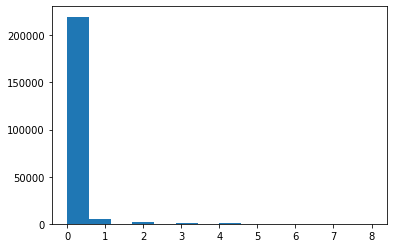

In [67]:
plt.hist([x[0] for x in mimiccxr_inconsistencies], bins=14)
plt.show()

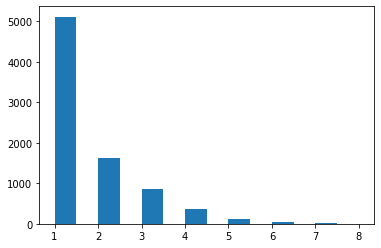

In [68]:
plt.hist([x[0] for x in mimiccxr_inconsistencies if x[0] > 0], bins=14)
plt.show()

In [60]:
inspect_inconsistency(
    mimiccxr_qa_adapted_reports__old,
    mimiccxr_chexpert_labels_per_report__old,
    mimiccxr_qa_adapted_reports__new,
    mimiccxr_chexpert_labels_per_report__new,
    mimiccxr_inconsistencies[5][1],
)

========= ORIGINAL REPORT =======
                                 FINAL REPORT
 HISTORY:  Status post CABG, evaluate left lower lobe effusion and atelectasis.
 
 CHEST, SINGLE AP PORTABLE VIEW.
 
 COMPARISON:  ___ chest x-ray at 8:04 a.m.
 
 Compared to the prior film, I doubt significant interval change.  Again seen
 is a pacemaker, sternotomy wires, enlarged cardiomediastinal silhouette,
 patchy opacity in left upper zone, increased retrocardiac density consistent
 with left lower lobe collapse and/or consolidation, and a small-to-moderate
 layering left effusion.  The right lung is grossly clear, with minimal
 vascular plethora, but no overt CHF.  Patchy cardiophrenic opacity is slightly
 improved.  No frank consolidation or effusion.
 
 IMPRESSION:  Grossly unchanged compared with one day prior.

========= OLD ==========
{'sentences': ['Grossly unchanged compared with one day prior.'], 'invalid': [0], 'unmatched': [], 'matched': [], 'qa': {}, 'question_ids': [], 'filepath': '/mnt/

## MIMIC-CXR comparisons (test set)

In [62]:
from medvqa.datasets.mimiccxr import MIMICCXR_STUDY_REGEX

def get_mimiccxr_test_set_indices(mimiccxr_reports):
    split_dict = {}
    
    mimiccxr_split_df = pd.read_csv('/mnt/data/mimic-cxr-jpg/mimic-cxr-2.0.0-split.csv')
    
    for study_id, subject_id, split in tqdm(zip(mimiccxr_split_df['study_id'],
                                           mimiccxr_split_df['subject_id'],
                                           mimiccxr_split_df['split'])):
        split_dict[(study_id, subject_id)] = split
    
    adapted_reports = mimiccxr_reports['reports']
    n = len(adapted_reports)
    
    indices = []
    for i in tqdm(range(n)):
        report = adapted_reports[i]
        _, subject_id, study_id = map(int, MIMICCXR_STUDY_REGEX.findall(report['filepath'])[0])
        key = (study_id, subject_id)
        if split_dict[key] == 'test':
            indices.append(i)
            
    return indices

In [63]:
mimiccxr_test_indices = get_mimiccxr_test_set_indices(mimiccxr_qa_adapted_reports__new)

377110it [00:00, 433741.65it/s]
100%|██████████| 227835/227835 [00:01<00:00, 139285.05it/s]


In [64]:
len(mimiccxr_test_indices)

3269

In [71]:
mimiccxr_test_indices_set = set(mimiccxr_test_indices)
mimiccxr_inconsistencies_test = [x for x in mimiccxr_inconsistencies if x[1] in mimiccxr_test_indices_set]

In [73]:
len(mimiccxr_inconsistencies_test)

3269

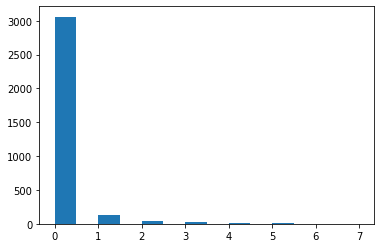

In [75]:
plt.hist([x[0] for x in mimiccxr_inconsistencies_test], bins=14)
plt.show()

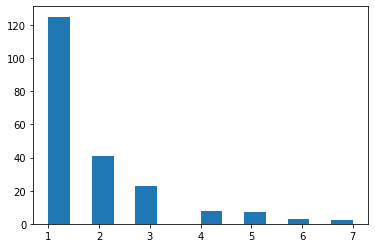

In [76]:
plt.hist([x[0] for x in mimiccxr_inconsistencies_test if x[0] > 0], bins=14)
plt.show()

In [84]:
inspect_inconsistency(
    mimiccxr_qa_adapted_reports__old,
    mimiccxr_chexpert_labels_per_report__old,
    mimiccxr_qa_adapted_reports__new,
    mimiccxr_chexpert_labels_per_report__new,
    mimiccxr_inconsistencies_test[100][1],
)

========= ORIGINAL REPORT =======
                                 FINAL REPORT
 INDICATION:  ___-year-old man with hypotension and syncope, evaluate for acute
 process.
 
 COMPARISON:  ___.
 
 FINDINGS:  Single portable upright chest radiograph was obtained.  Linear
 atelectasis at the right base is more discrete compared to prior exam.  No
 consolidation, effusion or pneumothorax is present.  Moderate cardiomegaly is
 stable.  A tiny right effusion is noted.  Surgical clips and sternotomy wires
 are intact.  A left chest cardiac device has two leads in stable position.  
 
 IMPRESSION:  Tiny right pleural effusion.

========= OLD ==========
{'sentences': ['Single portable upright chest radiograph was obtained.', 'Linear atelectasis at the right base is more discrete compared to prior exam.', 'No consolidation , effusion or pneumothorax is present', 'Moderate cardiomegaly is stable', 'A tiny right effusion is noted', 'Surgical clips and sternotomy wires are intact', 'A left chest card

## Comparisons IU X-ray

In [85]:
iuxray_inconsistencies = rank_by_number_inconsistencies(
    iuxray_chexpert_labels_per_report__old,
    iuxray_chexpert_labels_per_report__new,
)

In [86]:
iuxray_inconsistencies[:10]

[(2, 3165),
 (2, 2453),
 (2, 2188),
 (2, 414),
 (1, 3484),
 (1, 3072),
 (1, 2731),
 (1, 2704),
 (1, 2624),
 (1, 1963)]

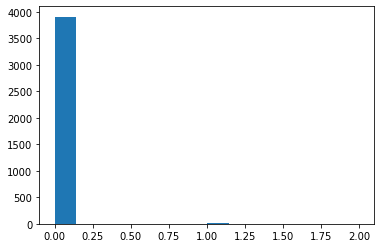

In [87]:
plt.hist([x[0] for x in iuxray_inconsistencies], bins=14)
plt.show()

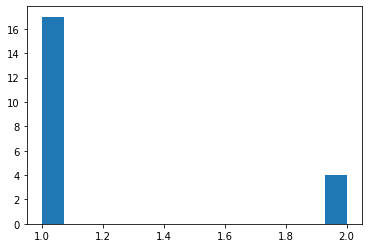

In [88]:
plt.hist([x[0] for x in iuxray_inconsistencies if x[0] > 0], bins=14)
plt.show()

In [95]:
inspect_inconsistency(
    iuxray_qa_adapted_reports__old,
    iuxray_chexpert_labels_per_report__old,
    iuxray_qa_adapted_reports__new,
    iuxray_chexpert_labels_per_report__new,
    iuxray_inconsistencies[1][1],
    path_key='filename',
)

========= OLD ==========
{'sentences': ['No focal consolidation , pneumothorax or definite pleural effusion', 'Heart size and pulmonary vascularity normal , no mediastinal widening characteristic in appearance of vascular injury', 'No acute osseous injury XXXX demonstrated', 'No acute XXXX related findings', 'Please note that nondisplaced fractures may not be demonstrated.'], 'invalid': [4], 'unmatched': [3], 'matched': [0, 1, 2], 'qa': {'68': [0], '73': [0], '32': [0], '48': [1], '76': [1], '63': [1], '54': [1, 2], '16': [2]}, 'question_ids': [68, 73, 32, 48, 76, 63, 54, 16], 'filename': '1216.xml'}

[1 0 0 0 0 0 0 0 0 0 0 0 0 0]
No Finding

========= NEW ==========
{'sentences': ['No focal consolidation , pneumothorax or definite pleural effusion', 'Heart size and pulmonary vascularity normal , no mediastinal widening characteristic in appearance of vascular injury', 'No acute osseous injury XXXX demonstrated', 'No acute XXXX related findings', 'Please note that nondisplaced fracture